In [1]:
import numpy as np
import math
import random
import time
from gurobipy import*
from gurobipy import GRB
import matplotlib.pyplot as plt
import pandas as pd

## Función para generación aleatoria de hipergrafos

In [2]:
def rand_hgraf(n,m,d):
    E = np.random.randint(2,d+1,size=(m))
    M = np.arange(m)
    N = np.arange(n)
    A = np.zeros((n,m))
    
    for j in M:
        t = 0
        while t < E[j]:
            s = int(np.random.choice(N,size=1))
            A[s,j] = 1
            t = np.sum(A[:,j])
    return A

In [3]:
#Tamaño promedio de las hiperaristas
def prom(A):
    m = A.shape[1]
    P = []
    for y in range(m):
        P.append(sum(A[:,y]))
    p = np.average(P)
    return p

#Tamaño máximo de las hiperaristas
def tamax(A):
    S = np.sum(A,axis=0)
    m = int(np.max(S))
    return m

#Vértices cubiertos por hiperaristas
def vert_cover(A,h):
    n = A.shape[0]
    S= np.zeros(n)
    for j in h:
        S += A[:,j]
    vc = np.where(S!=0)[0]
    return len(vc)

def union(A,s):
    U = np.sum(A[:,s],axis=1)
    u = np.where(U!=0)[0]
    return u

#Vértices en la interesección de las hiperaristas
def inter(A,e1,e2):
    I = A[:,e1]+A[:,e2]
    i = np.where(I>1)[0]
    return i

## Funciones para desigualdades válidas

In [4]:
#Hiperaristas tipo hoja
def hoja(A):
    n = A.shape[0]
    S = np.sum(A,axis=1)
    h = []
    for i in range(n):
        if S[i]==1:
            j = np.where(A[i,:]==1)[0][0]
            h.append(j)
    return h

#Hiperaristas de tamaño mayor a n/k
def hmayor(A,r):
    m = A.shape[1]   #número de hiperaristas
    H = []
    for y in range(m):
        if sum(A[:,y])>r:
            H.append(y)
    return H

#Hiperaristas contenidas
def cont(A):
    m = A.shape[1]   #número de hiperaristas
    tmax = tamax(A)
    h = {}
    for t in range(2,tmax+1):
        E = []
        for j in range(m):
            if sum(A[:,j])==t:
                E.append(j)
        h.update({t: E})
    C = {}
    for c_out in range(tmax,2,-1):
        for eo in h[c_out]:
            L = []
            for c_in in range(c_out-1,1,-1):
                for ei in h[c_in]:
                    d = A[:,ei]+A[:,eo]
                    s = len(np.where(d==2)[0])
                    if s == c_in:
                        L.append(ei)
            if len(L)>0:
                C.update({eo:L})
    return C

#Conjuntos minimales de 3 elementos
def minimal3(A,nk):
    m = A.shape[1]
    M = [x for x in range(m)]
    S = []
    for x in M:
        s = []
        i = M.index(x)
        for y in M[i+1:]:
            i = M.index(y)
            for z in M[i+1:]:
                if vert_cover(A,[x,y])<=nk and vert_cover(A,[x,z])<=nk and vert_cover(A,[y,z])<=nk and vert_cover(A,[x,y,z])>nk:
                    S.append([x,y,z])
                else:
                    break
    return S

## Formulación $\mathcal{F}1$

In [5]:
def F1(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    r = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == n/K for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,nods,g

## Formulación $\mathcal{F}1$ con planos cortantes

In [6]:
#Restricción tipo hoja
def F1_pc1(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Hiperaristas tipo hoja
    for h in hoja(A):
        modelo.addConstr(quicksum(y[h,k] for k in C) == 1)
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,nods,g

In [7]:
#Eliminación de simetrías
def F1_pc2(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [8]:
#Hiperaristas contenidas
def F1_pc3(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        count=0
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods=modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [9]:
#Restricción tipo knapsack
def F1_pc4(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    #Desigualdades tipo knapsack
    y_node = {(j,k): 0 for j in M for k in C}
    Min3 = minimal3(A,nk)
    def mycallback(modelo,where):
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for s in Min3:
                    for k in C:
                        ds = quicksum(y_node[j,k] for j in s)
                        if ds.getValue()>len(s)-1:
                            modelo.cbCut(quicksum(y[j,k] for j in s) <= len(s)-1)
                            modelo._cbCuts+=1
                    else:
                        pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [10]:
def F1_pc_23(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [11]:
def F1_pc_24(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    #Desigualdades tipo knapsack
    y_node = {(j,k): 0 for j in M for k in C}
    Min3 = minimal3(A,nk)
    def mycallback(modelo,where):
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for s in Min3:
                    for k in C:
                        ds = quicksum(y_node[j,k] for j in s)
                        if ds.getValue()>len(s)-1:
                            modelo.cbCut(quicksum(y[j,k] for j in s) <= len(s)-1)
                            modelo._cbCuts+=1
                    else:
                        pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [12]:
def F1_pc_34(A,W,K):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    nk = int(n/K)     #Tamaño de cada partición
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    modelo.Params.PreCrush = 1
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.3)
    modelo.addConstrs(quicksum(x[i,k] for i in N) == nk for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)

    #Hiperaristas contenidas y Desigualdades tipo knapsack
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    Min3 = minimal3(A,nk)
    def mycallback(modelo,where):
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts += 1
                        else:
                            pass
                for s in Min3:
                    for k in C:
                        ds = quicksum(y_node[j,k] for j in s)
                        if ds.getValue()>len(s)-1:
                            modelo.cbCut(quicksum(y[j,k] for j in s) <= len(s)-1)
                            modelo._cbCuts += 1
                    else:
                        pass

    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [13]:
n = 50
m = 300
d = 2
#d = 10
K = 2
nk = int(n/K)
A = rand_hgraf(n,m,d)
W = np.random.randint(1,21,size=m)

In [14]:
V,E,tr,sol,nod,g = F1(A,W,K)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-03


In [15]:
nod

1.0

In [16]:
V1,E1,tr1,sol1,nod1,g1 = F1_pc_34(A,W,K)

In [17]:
nod1

[1.0, 0]

In [18]:
sol,sol1

(83.0, 83.0)

In [19]:
tr,tr1

(0.22430801391601562, 0.05354881286621094)

## Pruebas

In [20]:
P = np.array([[45,100],
              [45,200],
              [45,500],
              [90,150],
              [90,500],
              [90,1000],
              [150,300],
              [150,800],
              [150,1500],
              [180,400],
              [180,1000],
              [180,2000]])

tam = {45:[2,5,10],
       90:[2,5,10,20],
       150:[2,5,10,20],
       180:[2,5,10,20]}
R = []

for p in P:
    for t in tam[p[0]]:
        n = p[0]
        m = p[1]
        K = 3
        sol =None
        tr=0
        i=0
        while sol==None and tr<1:
            A = rand_hgraf(n,m,t)
            pr = prom(A)
            W = np.random.randint(1,21,size=m)
            print(p,t)
            if t==2 and m/n <3:
                V,E,tr,sol,nod,g = F1(A,W,K)
                V1,E1,tr1,sol1,nod1,g1 = F1_pc1(A,W,K)
                V2,E2,tr2,sol2,nod2,g2 = F1_pc2(A,W,K)
                V3,E3,tr3,sol3,nod3,g3 = F1_pc3(A,W,K)
                V4,E4,tr4,sol4,nod4,g4 = F1_pc4(A,W,K)
                V23,E23,tr23,sol23,nod23,g23 = F1_pc_23(A,W,K)
                V24,E24,tr24,sol24,nod24,g24 = F1_pc_24(A,W,K)
                V34,E34,tr34,sol34,nod34,g34 = F1_pc_34(A,W,K)
            else:
                V,E,tr,sol,nod,g = F1(A,W,K)
                V1,E1,tr1,sol1,nod1,g1 = None,None,None,None,None,None
                V2,E2,tr2,sol2,nod2,g2 = F1_pc2(A,W,K)
                V3,E3,tr3,sol3,nod3,g3 = F1_pc3(A,W,K)
                V4,E4,tr4,sol4,nod4,g4 = F1_pc4(A,W,K)
                V23,E23,tr23,sol23,nod23,g23 = F1_pc_23(A,W,K)
                V24,E24,tr24,sol24,nod24,g24 = F1_pc_24(A,W,K)
                V34,E34,tr34,sol34,nod34,g34 = F1_pc_34(A,W,K)
            i += 1
            if i >=10:
                break        
        Tr=[tr,tr1,tr2,tr3,tr4,tr23,tr24,tr34]
        S=[sol,sol1,sol2,sol3,sol4,sol23,sol24,sol34]
        Nd=[nod,nod1,nod2,nod3,nod4,nod23,nod24,nod34]
        G=[g,g1,g2,g3,g4,g23,g24,g34]
        print(Tr,S)
        print(Nd)
        R.append([p,pr,t,Tr,S,Nd,G])
    

[ 45 100] 2
[0.05373382568359375, 0.021940231323242188, 0.012964248657226562, 0.0109710693359375, 0.0109710693359375, 0.012966156005859375, 0.012990951538085938, 0.011968612670898438] [153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 153.0]
[1.0, 1.0, 1.0, [1.0, 0], [1.0, 0], [1.0, 0], [1.0, 0], [1.0, 0]]
[ 45 100] 5
[0.6948394775390625, None, 1.6836776733398438, 2.167642593383789, 1.0748558044433594, 1.5564537048339844, 2.3612823486328125, 2.9755592346191406] [86.0, None, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0]
[1836.0, None, 1831.0, [4256.0, 54], [1836.0, 0], [2727.0, 48], [1831.0, 0], [4256.0, 54]]
[ 45 100] 10
[3.3252639770507812, None, 2.964212417602539, 4.1884918212890625, 51.69693565368652, 3.720273971557617, 103.15087509155273, 48.923465728759766] [147.0, None, 147.0, 147.0, 147.0, 147.0, 147.0, 147.0]
[1543.0, None, 1503.0, [1778.0, 17], [1675.0, 74], [2749.0, 22], [4361.0, 305], [1554.0, 131]]
[ 45 200] 2
[0.03143119812011719, None, 0.015954971313476562, 0.031917572021484375, 0.0

[1800.04856300354, None, 1800.0667133331299, 1802.2475395202637, 1800.5827713012695, 1800.5861473083496, 1800.6584033966064, 1801.4601364135742] [166.0, None, 162.0, 168.0, 166.0, 150.0, 162.0, 168.0]
[96830.0, None, 93069.0, [101861.0, 1195], [86671.0, 0], [103376.0, 970], [81939.0, 0], [102060.0, 1195]]
[150 800] 20
[1800.0627326965332, None, 1800.0298671722412, 1800.2226104736328, 1800.1432151794434, 1801.3432865142822, 1801.4182834625244, 1803.971441268921] [308.0, None, 299.0, 323.0, 308.0, 321.0, 299.0, 323.0]
[10671.0, None, 11557.0, [10854.0, 185], [9929.0, 0], [11507.0, 165], [10827.0, 0], [10271.0, 185]]
[ 150 1500] 2
[0.15517425537109375, None, 0.21811485290527344, 0.14020729064941406, 0.13974571228027344, 0.22748756408691406, 0.2345142364501953, 0.1401805877685547] [162.0, None, 162.0, 162.0, 162.0, 162.0, 162.0, 162.0]
[1.0, None, 1.0, [1.0, 0], [1.0, 0], [1.0, 0], [1.0, 0], [1.0, 0]]
[ 150 1500] 5
[28.89866065979004, None, 49.28999900817871, 90.55390930175781, 48.37021064

In [5]:
e='$\alpha$'
e

'$\x07lpha$'

In [22]:
Df = pd.DataFrame(columns=['Instancia','Prom','Tam. max','Plano cortante','Valor Función Objetivo','GAP', 'Nodos','Tiempo [s]'],
                 index=np.arange(len(R)*8))

pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','Tipo knapsack','ES+CO','ES+KS','CO+KS']

for x in range(len(R)):
    for y in range(8):
        Df.at[8*x+y,'Instancia']=R[x][0]
        Df.at[8*x+y,'Prom']=R[x][1]
        Df.at[8*x+y,'Tam. max']=R[x][2]
        Df.at[8*x+y,'Plano cortante']=pc[y]
        Df.at[8*x+y,'Valor Función Objetivo']=R[x][4][y]
        Df.at[8*x+y,'GAP']=R[x][6][y]
        Df.at[8*x+y,'Nodos']=R[x][5][y]
        Df.at[8*x+y,'Tiempo [s]']=R[x][3][y]
Df

,Instancia,Prom,Tam. max,Plano cortante,Valor Función Objetivo,GAP,Nodos,Tiempo [s]
0,"[45, 100]",2,2,Ninguno,153,0,1,0.0537338
1,"[45, 100]",2,2,Tipo hoja,153,0,1,0.0219402
2,"[45, 100]",2,2,Elim. simetrías,153,0,1,0.0129642
3,"[45, 100]",2,2,Hiperaristas contenidas,153,0,"[1.0, 0]",0.0109711
4,"[45, 100]",2,2,Tipo knapsack,153,0,"[1.0, 0]",0.0109711
...,...,...,...,...,...,...,...,...
355,"[180, 2000]",11.046,20,Hiperaristas contenidas,227,88.9868,"[5579.0, 495]",1800.85
356,"[180, 2000]",11.046,20,Tipo knapsack,239,90.3766,"[5441.0, 0]",1800.19
357,"[180, 2000]",11.046,20,ES+CO,249,91.1647,"[6217.0, 847]",1800.15
358,"[180, 2000]",11.046,20,ES+KS,245,91.0204,"[6810.0, 0]",1800.64


In [23]:
Df.to_excel('pruebas_F1.xlsx')

In [24]:
df = pd.read_excel('pruebas_F1.xlsx') 
INST = df['Instancia'].tolist()
Tiempo = df['Tiempo [s]'].tolist()
Plano = df['Plano cortante'].tolist()
GAP = df['GAP'].tolist()
TAM = df['Tam. max'].tolist()
P = list([[45,100],
          [45,200],
          [45,500],
          [90,150],
          [90,500],
          [90,1000],
          [150,300],
          [150,800],
          [150,1500],
          [180,400],
          [180,1000],
          [180,2000]])
pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','Tipo knapsack','ES+CO','ES+KS','CO+KS']

In [25]:
I = []
for x in P:
    if x[0] == 45:
        for y in [2,5,10]:
            I.append([x,y])
    elif x[0] == 90:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 150:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 180:
        for y in [2,5,10,20]:
            I.append([x,y])
        

In [31]:
T_tam2 = []
T_tam5  = []
T_tam10  = []
T_tam20  = []
G_tam2  = []
G_tam5  = []
G_tam10  = []
G_tam20  = []
com2=[]
com5=[]
com10=[]
com20=[]

for x in range(len(I)):
    tam = I[x][1]
    if tam==2:
        tiempo = [Tiempo[8*x+y] for y in range(8)]
        T_tam2.append(tiempo)
        g = [GAP[8*x+y] for y in range(8)]
        G_tam2.append(g)
        com2.append(str(I[x][0]))
    elif tam==5:
        tiempo = [Tiempo[8*x+y] for y in range(8)]
        T_tam5.append(tiempo)
        g = [GAP[8*x+y] for y in range(8)]
        G_tam5.append(g)
        com5.append(str(I[x][0]))
    elif tam==10:
        tiempo = [Tiempo[8*x+y] for y in range(8)]
        T_tam10.append(tiempo)
        g = [GAP[8*x+y] for y in range(8)]
        G_tam10.append(g)
        com10.append(str(I[x][0]))
    elif tam==20:
        tiempo = [Tiempo[8*x+y] for y in range(8)]
        T_tam20.append(tiempo)
        g = [GAP[8*x+y] for y in range(8)]
        G_tam20.append(g)
        com20.append(str(I[x][0]))

<ipython-input-62-1ee91e3ef749>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[0].set_xticklabels(com2,rotation=90)
<ipython-input-62-1ee91e3ef749>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[1].set_xticklabels(com2,rotation=90)
<ipython-input-62-1ee91e3ef749>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[0].set_xticklabels(com5,rotation=90)
<ipython-input-62-1ee91e3ef749>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[1].set_xticklabels(com5,rotation=90)
<ipython-input-62-1ee91e3ef749>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[0].set_xticklabels(com10,rotation=90)
<ipython-input-62-1ee91e3ef749>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[1].set_xticklabels(com10,rotation=90)
<ipython-input-62-1ee91e3ef749>:130: UserWarning: FixedFormatter sh

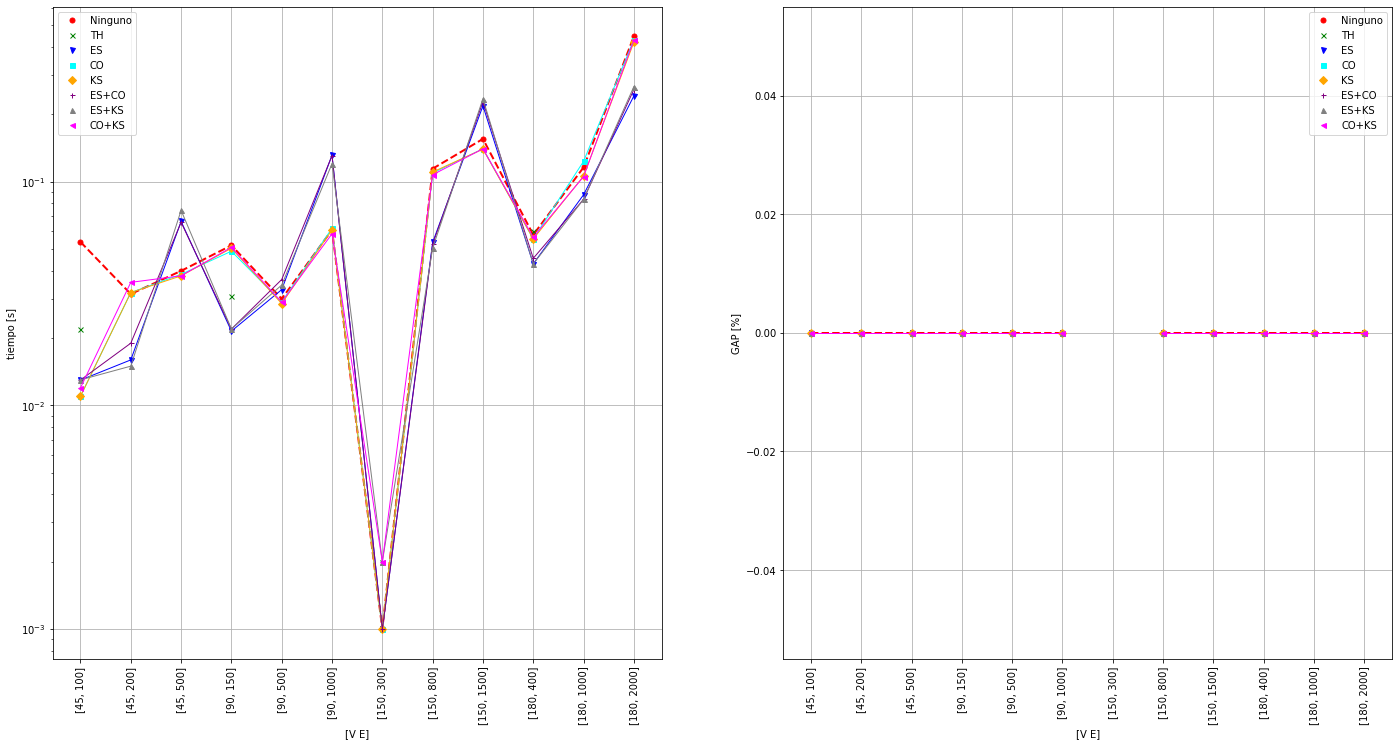

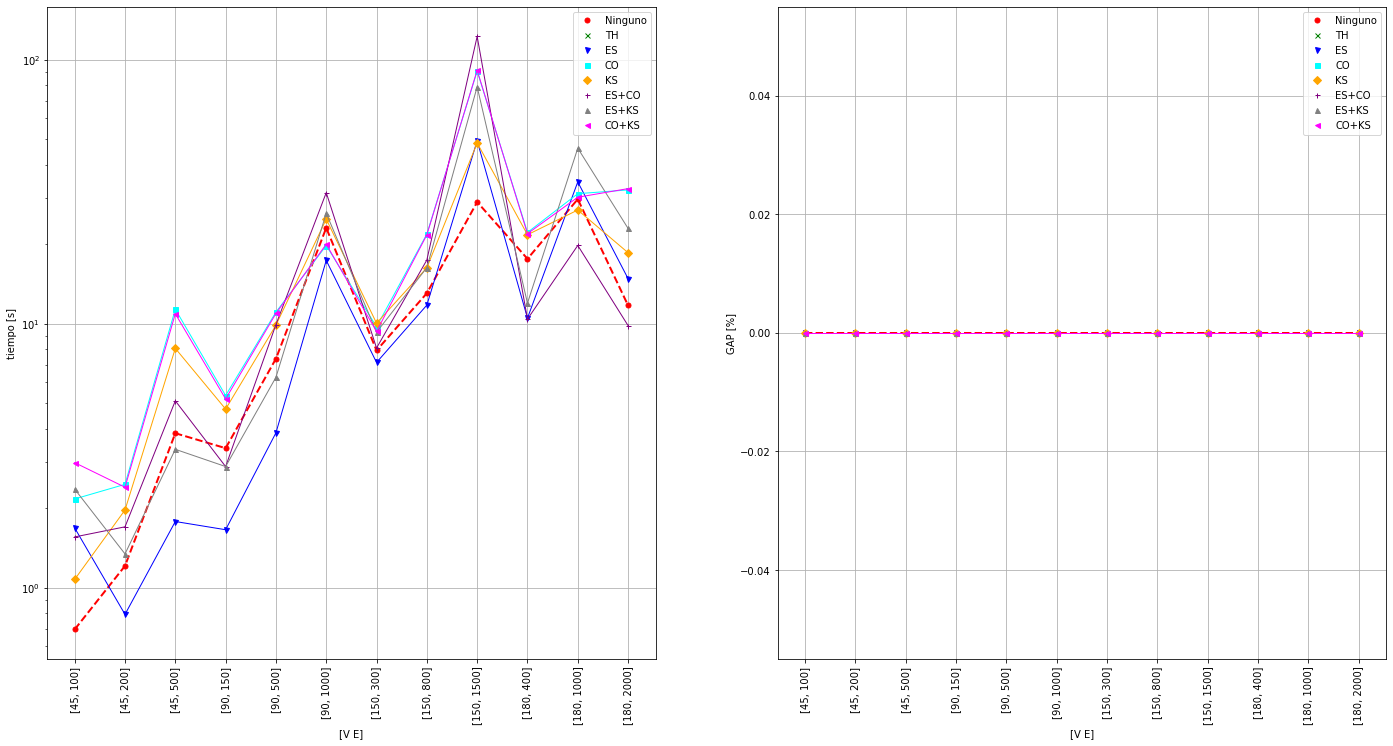

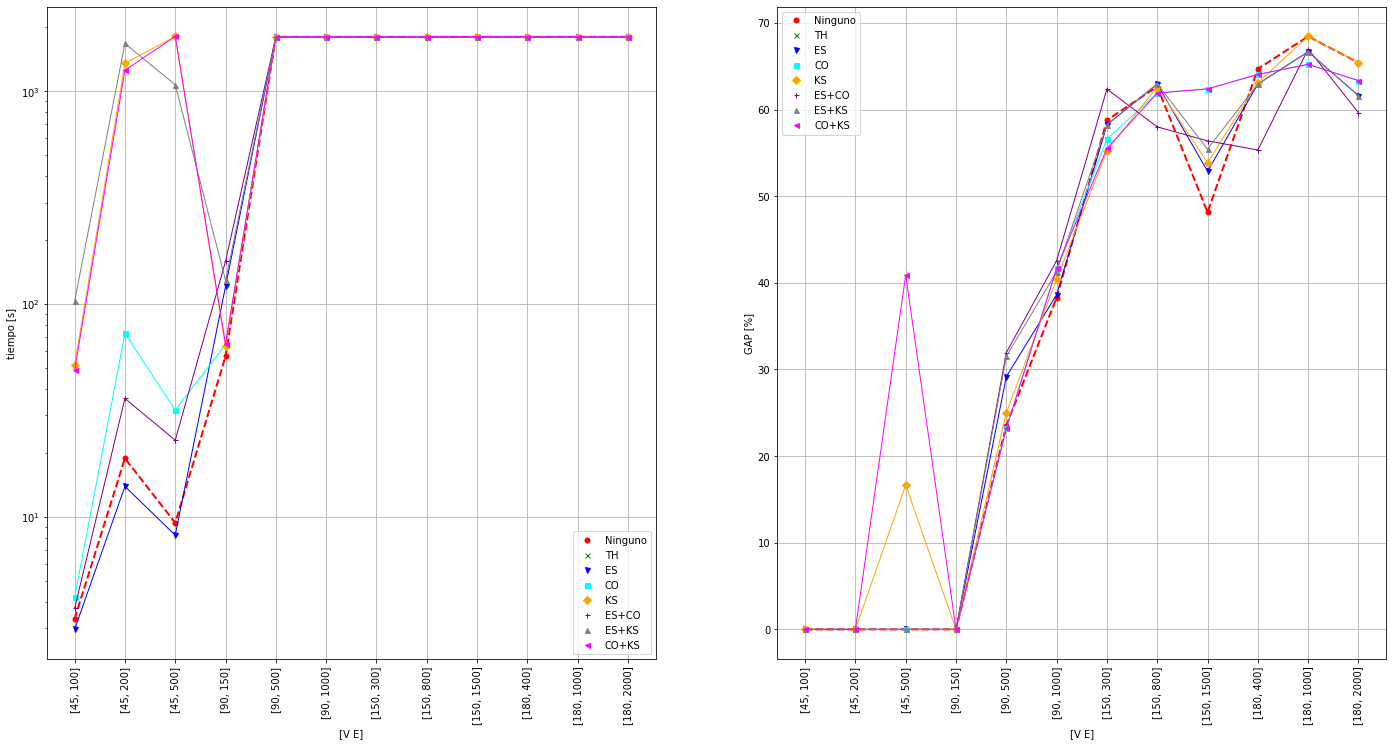

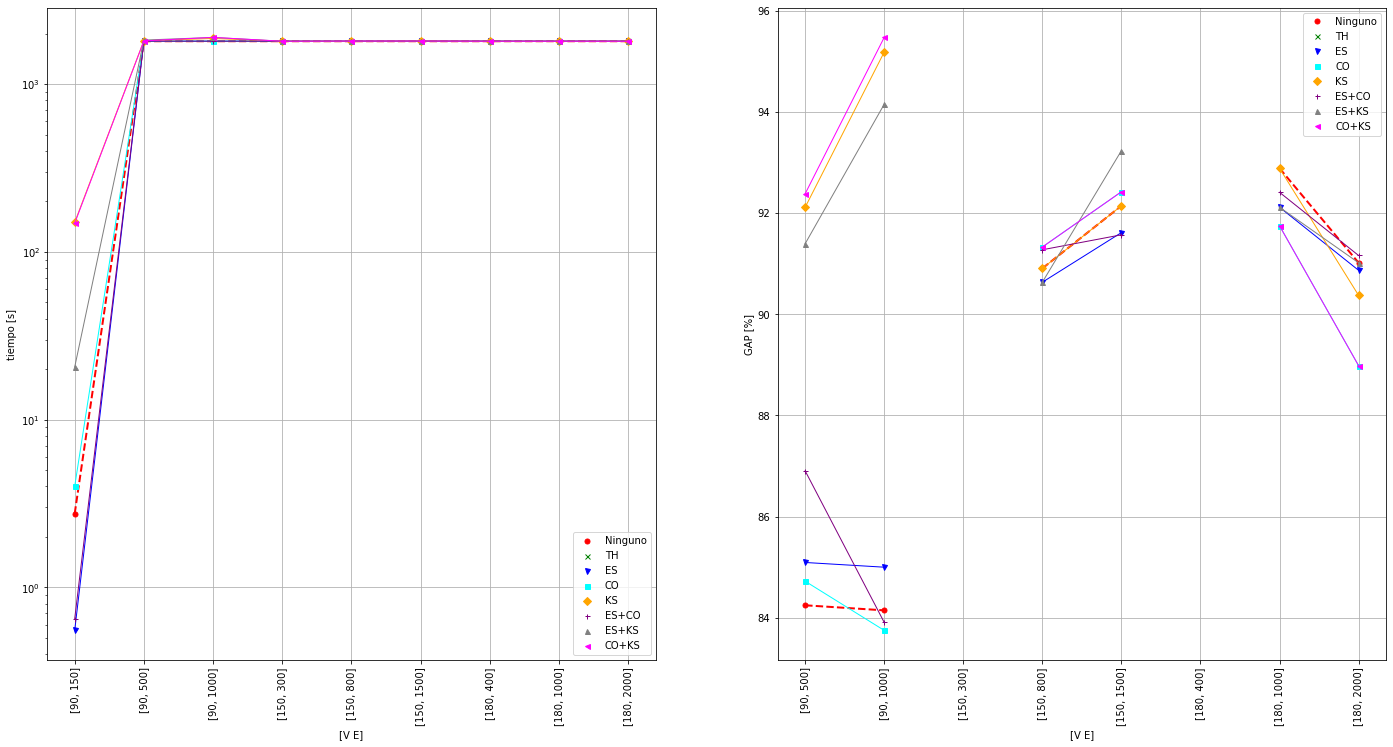

In [62]:
fig1 ,axs1 = plt.subplots(1,2,figsize=(24,12)) #tam2
fig2 ,axs2 = plt.subplots(1,2,figsize=(24,12)) #tam5
fig3 ,axs3 = plt.subplots(1,2,figsize=(24,12)) #tam10
fig4 ,axs4 = plt.subplots(1,2,figsize=(24,12)) #tam20

import matplotlib.lines as mlines

line_parm = {
            0:{'color':'red', 'marker':'o', 'linestyle':'dashed','linewidth':2, 'markersize':5, 'label':'Ninguno'},
            1:{'color':'green', 'marker':'x', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'TH'},
            2:{'color':'blue', 'marker':'v', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES'},
            3:{'color':'cyan', 'marker':'s', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'CO'},
            4:{'color':'orange', 'marker':'D', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'KS'},
            5:{'color':'purple', 'marker':'+', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES+CO'},
            6:{'color':'gray', 'marker':'^', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES+KS'},
            7:{'color':'magenta', 'marker':'<', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'CO+KS'}
}
mod = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Ninguno'),
     mlines.Line2D([], [], color='green', marker='x', linestyle='None',
                        markersize=5, label='TH'),
     mlines.Line2D([], [], color='blue', marker='v', linestyle='None',
                        markersize=5, label='ES'),
     mlines.Line2D([], [], color='cyan', marker='s', linestyle='None',
                        markersize=5, label='CO'),
     mlines.Line2D([], [], color='orange', marker='D', linestyle='None',
                        markersize=5, label='KS'),
     mlines.Line2D([], [], color='purple', marker='+', linestyle='None',
                        markersize=5, label='ES+CO'),
     mlines.Line2D([], [], color='gray', marker='^', linestyle='None',
                        markersize=5, label='ES+KS'),
     mlines.Line2D([], [], color='magenta', marker='<', linestyle='None',
                              markersize=5, label='CO+KS')]

#TAM2
axs1[0].set_xticklabels(com2,rotation=90)
axs1[0].set_xlabel('[V E]')
axs1[0].set_yscale('log')
axs1[0].set_ylabel('tiempo [s]')
axs1[0].plot(com2,[x[0] for x in T_tam2],**line_parm[0])
axs1[0].plot(com2,[x[1] for x in T_tam2],**line_parm[1])
axs1[0].plot(com2,[x[2] for x in T_tam2],**line_parm[2])
axs1[0].plot(com2,[x[3] for x in T_tam2],**line_parm[3])
axs1[0].plot(com2,[x[4] for x in T_tam2],**line_parm[4])
axs1[0].plot(com2,[x[5] for x in T_tam2],**line_parm[5])
axs1[0].plot(com2,[x[6] for x in T_tam2],**line_parm[6])
axs1[0].plot(com2,[x[7] for x in T_tam2],**line_parm[7])
axs1[0].legend(handles=mod)
axs1[0].grid(True)
axs1[1].set_xticklabels(com2,rotation=90)
axs1[1].set_xlabel('[V E]')
axs1[1].set_ylabel('GAP [%]')
axs1[1].plot(com2,[x[0] for x in G_tam2],**line_parm[0])
axs1[1].plot(com2,[x[1] for x in G_tam2],**line_parm[1])
axs1[1].plot(com2,[x[2] for x in G_tam2],**line_parm[2])
axs1[1].plot(com2,[x[3] for x in G_tam2],**line_parm[3])
axs1[1].plot(com2,[x[4] for x in G_tam2],**line_parm[4])
axs1[1].plot(com2,[x[5] for x in G_tam2],**line_parm[5])
axs1[1].plot(com2,[x[6] for x in G_tam2],**line_parm[6])
axs1[1].plot(com2,[x[7] for x in G_tam2],**line_parm[7])
axs1[1].legend(handles=mod)
axs1[1].grid(True)
#fig1.suptitle('$|e_{max}|=2$',fontsize=36)
fig1.savefig('F1_tam2.jpg',bbox_inches='tight',dpi=300)

#TAM5
axs2[0].set_xticklabels(com5,rotation=90)
axs2[0].set_xlabel('[V E]')
axs2[0].set_yscale('log')
axs2[0].set_ylabel('tiempo [s]')
axs2[0].plot(com5,[x[0] for x in T_tam5],**line_parm[0])
axs2[0].plot(com5,[x[1] for x in T_tam5],**line_parm[1])
axs2[0].plot(com5,[x[2] for x in T_tam5],**line_parm[2])
axs2[0].plot(com5,[x[3] for x in T_tam5],**line_parm[3])
axs2[0].plot(com5,[x[4] for x in T_tam5],**line_parm[4])
axs2[0].plot(com5,[x[5] for x in T_tam5],**line_parm[5])
axs2[0].plot(com5,[x[6] for x in T_tam5],**line_parm[6])
axs2[0].plot(com5,[x[7] for x in T_tam5],**line_parm[7])
axs2[0].legend(handles=mod)
axs2[0].grid(True)
axs2[1].set_xticklabels(com5,rotation=90)
axs2[1].set_xlabel('[V E]')
axs2[1].set_ylabel('GAP [%]')
axs2[1].plot(com5,[x[0] for x in G_tam5],**line_parm[0])
axs2[1].plot(com5,[x[1] for x in G_tam5],**line_parm[1])
axs2[1].plot(com5,[x[2] for x in G_tam5],**line_parm[2])
axs2[1].plot(com5,[x[3] for x in G_tam5],**line_parm[3])
axs2[1].plot(com5,[x[4] for x in G_tam5],**line_parm[4])
axs2[1].plot(com5,[x[5] for x in G_tam5],**line_parm[5])
axs2[1].plot(com5,[x[6] for x in G_tam5],**line_parm[6])
axs2[1].plot(com5,[x[7] for x in G_tam5],**line_parm[7])
axs2[1].legend(handles=mod)
axs2[1].grid(True)
#fig2.suptitle('$|e_{max}|=5$',fontsize=36)
fig2.savefig('F1_tam5.jpg',bbox_inches='tight',dpi=300)

#TAM10
axs3[0].set_xticklabels(com10,rotation=90)
axs3[0].set_xlabel('[V E]')
axs3[0].set_yscale('log')
axs3[0].set_ylabel('tiempo [s]')
axs3[0].plot(com10,[x[0] for x in T_tam10],**line_parm[0])
axs3[0].plot(com10,[x[1] for x in T_tam10],**line_parm[1])
axs3[0].plot(com10,[x[2] for x in T_tam10],**line_parm[2])
axs3[0].plot(com10,[x[3] for x in T_tam10],**line_parm[3])
axs3[0].plot(com10,[x[4] for x in T_tam10],**line_parm[4])
axs3[0].plot(com10,[x[5] for x in T_tam10],**line_parm[5])
axs3[0].plot(com10,[x[6] for x in T_tam10],**line_parm[6])
axs3[0].plot(com10,[x[7] for x in T_tam10],**line_parm[7])
axs3[0].legend(handles=mod)
axs3[0].grid(True)
axs3[1].set_xticklabels(com10,rotation=90)
axs3[1].set_xlabel('[V E]')
axs3[1].set_ylabel('GAP [%]')
axs3[1].plot(com10,[x[0] for x in G_tam10],**line_parm[0])
axs3[1].plot(com10,[x[1] for x in G_tam10],**line_parm[1])
axs3[1].plot(com10,[x[2] for x in G_tam10],**line_parm[2])
axs3[1].plot(com10,[x[3] for x in G_tam10],**line_parm[3])
axs3[1].plot(com10,[x[4] for x in G_tam10],**line_parm[4])
axs3[1].plot(com10,[x[5] for x in G_tam10],**line_parm[5])
axs3[1].plot(com10,[x[6] for x in G_tam10],**line_parm[6])
axs3[1].plot(com10,[x[7] for x in G_tam10],**line_parm[7])
axs3[1].legend(handles=mod)
axs3[1].grid(True)
#fig3.suptitle('$|e_{max}|=10$',fontsize=36)
fig3.savefig('F1_tam10.jpg',bbox_inches='tight',dpi=300)

#TAM20
axs4[0].set_xticklabels(com20,rotation=90)
axs4[0].set_xlabel('[V E]')
axs4[0].set_yscale('log')
axs4[0].set_ylabel('tiempo [s]')
axs4[0].plot(com20,[x[0] for x in T_tam20],**line_parm[0])
axs4[0].plot(com20,[x[1] for x in T_tam20],**line_parm[1])
axs4[0].plot(com20,[x[2] for x in T_tam20],**line_parm[2])
axs4[0].plot(com20,[x[3] for x in T_tam20],**line_parm[3])
axs4[0].plot(com20,[x[4] for x in T_tam20],**line_parm[4])
axs4[0].plot(com20,[x[5] for x in T_tam20],**line_parm[5])
axs4[0].plot(com20,[x[6] for x in T_tam20],**line_parm[6])
axs4[0].plot(com20,[x[7] for x in T_tam20],**line_parm[7])
axs4[0].legend(handles=mod)
axs4[0].grid(True)
axs4[1].set_xticklabels(com20,rotation=90)
axs4[1].set_xlabel('[V E]')
axs4[1].set_ylabel('GAP [%]')
axs4[1].plot(com20,[x[0] for x in G_tam20],**line_parm[0])
axs4[1].plot(com20,[x[1] for x in G_tam20],**line_parm[1])
axs4[1].plot(com20,[x[2] for x in G_tam20],**line_parm[2])
axs4[1].plot(com20,[x[3] for x in G_tam20],**line_parm[3])
axs4[1].plot(com20,[x[4] for x in G_tam20],**line_parm[4])
axs4[1].plot(com20,[x[5] for x in G_tam20],**line_parm[5])
axs4[1].plot(com20,[x[6] for x in G_tam20],**line_parm[6])
axs4[1].plot(com20,[x[7] for x in G_tam20],**line_parm[7])
axs4[1].legend(handles=mod)
axs4[1].grid(True)
#fig4.suptitle('$|e_{max}|=20$',fontsize=36)
fig4.savefig('F1_tam20.jpg',bbox_inches='tight',dpi=300)
plt.show()